In [29]:
#Import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
from mpl_toolkits.basemap import Basemap
from scipy.stats import beta
from collections import OrderedDict
import matplotlib.lines as mlines

In [37]:
#Load datasets
airport = pd.read_csv('/Users/ash/Downloads/airports.dat', names=['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
                      'Timezone', 'DST', 'TZ', 'Type', 'Source'], index_col = 0)
route = pd.read_csv('/Users/ash/Downloads/routes.dat', names=['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
                    'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'Equipment'])

#Clean data, drop NAs
airport = airport.dropna(subset=['IATA'])
airport = airport[airport['IATA'] != '\\N']
route = route[(route['Source Airport'] != '\\N')]
route = route[(route['Dest Airport'] != '\\N')]

In [3]:
airport.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,TZ,Type,Source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
route.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [38]:
#Select US airports and routes
airport_us = airport[airport['Country'] == 'United States']
airport_us = airport_us[['Lat', 'Long', 'IATA']]
us_airport_iata = airport_us['IATA'].unique()
route_us = route[(route['Source Airport'].isin(us_airport_iata))]
route_us = route_us[(route_us['Dest Airport'].isin(us_airport_iata))]
route_us =  pd.DataFrame(route_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index())
route_us.columns = ['Source', 'Dest', 'Count']

airport_us = airport_us.reset_index()
airport_us['Size'] = np.nan
#Creat networkx graph
g = nx.from_pandas_edgelist(route_us, source = 'Source', target = 'Dest', \
                                edge_attr = 'Count',create_using = nx.DiGraph()) 

#Calculate relevant information from the data to parse to the nodes
for airport in list(g.nodes): 
    n_airline = route_us[route_us['Source'] == airport]['Count'].sum()
    index = airport_us[airport_us['IATA'] == airport].index[0]
    airport_us.iloc[index,-1] = int(n_airline)
airport_us = airport_us.dropna(subset=['Size'])

for node in g.nodes(): 
    g.nodes[node]['size'] = airport_us[airport_us['IATA'] == node]['Size'].values[0]

i = 0
for edge in g.edges(): 
    g.edges[edge]['route_max_capacity'] =  route_us['Count'][i]
    i += 1

#Selecting only a subset of big nodes if neccessary
# small_nodes = [node for node in g.nodes() if g.nodes[node]['size'] < 150] 
# for node in small_nodes:
#     g.remove_node(node)

In [39]:
airport_us.head()

,ID,Lat,Long,IATA,Size
0,3411,70.134003,-143.582001,BTI,2.0
1,3413,68.875099,-166.110001,LUR,1.0
2,3414,69.732903,-163.005005,PIZ,1.0
3,3415,19.721399,-155.048004,ITO,4.0
5,3417,66.913902,-151.529007,BTT,4.0


In [7]:
route_us.head()

,Source,Dest,Count
0,ABE,ATL,3
1,ABE,CLT,2
2,ABE,DTW,1
3,ABE,MYR,1
4,ABE,ORD,1


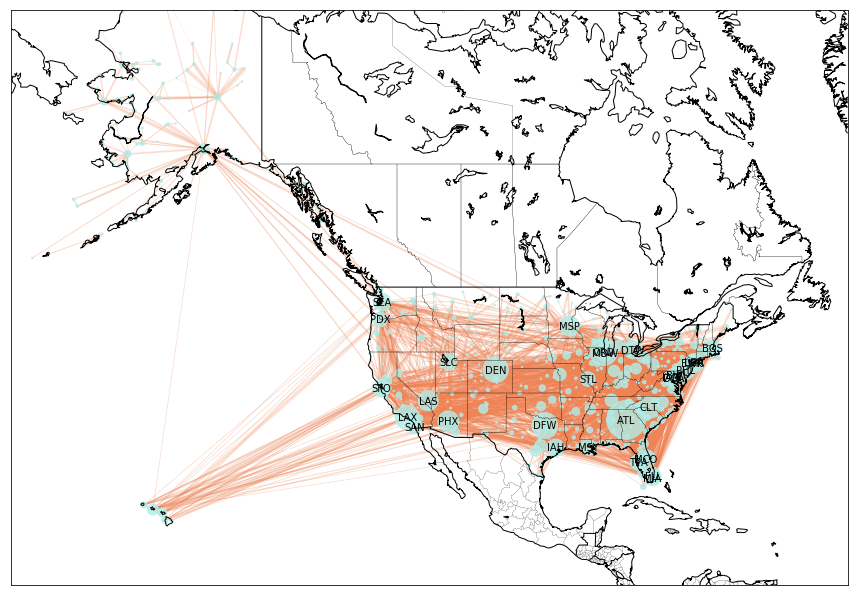

In [40]:
#Visualize flight network
plt.figure(figsize=(15,20))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,urcrnrlat=70,lat_ts=0,resolution='l',suppress_ticks=True)

mx, my = m(airport_us['Long'].values, airport_us['Lat'].values)
pos = {}
for count, elem in enumerate (airport_us['IATA']):
    pos[elem] = (mx[count], my[count])

nx.draw_networkx_nodes(G = g, pos = pos, node_list = g.nodes(), node_color = '#B1EDE8', alpha = 0.8,
                       node_size = [g.nodes[node]['size']*2 for node in g.nodes()])
nx.draw_networkx_edges(G = g, pos = pos, edge_color='#EF8354', width = [g.edges[edge]['route_max_capacity']*0.5 for edge in g.edges()], 
                       alpha=0.2, arrows = False)
nx.draw_networkx_labels(G = g, pos = pos, font_size=10,
                        labels = {s:s for s in g.nodes() if airport_us[airport_us['IATA'] == s]['Size'].values[0] >=100})
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
plt.show()

In [9]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance_on_map(node1, node2): 
    '''
    Calculate the distance between two nodes on Earth based on their longtitudes/latitudes
    
    Inputs: 
        node1 (str): the name of the first node
        node2 (str): the name of the second node
    
    Outputs: the distance between two input nodes
        
    '''
    R = 6373.0 #Earth's radius (in km)

    lat1 = radians(airport_us[airport_us['IATA'] == node1]['Lat'].values[0])
    lon1 = radians(airport_us[airport_us['IATA'] == node1]['Long'].values[0])
    lat2 = radians(airport_us[airport_us['IATA'] == node2]['Lat'].values[0])
    lon2 = radians(airport_us[airport_us['IATA'] == node2]['Long'].values[0])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

#Calculate distances for all nodes in the US airports
for edge in g.edges(): 
    source, dest = edge
    g.edges[edge]['distance'] = calculate_distance_on_map(source, dest)

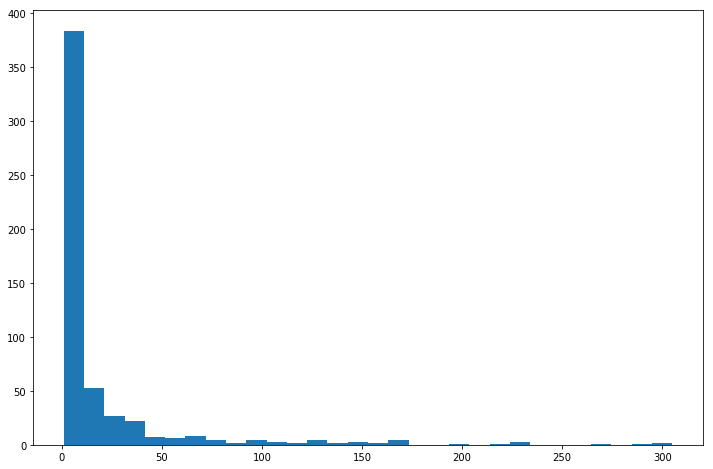

In [10]:
#Network degree
degree = [g.degree[node] for node in g.nodes()]
plt.figure(figsize=(12,8))
plt.hist(degree, bins=30)
plt.show()

In [112]:
class TransportationSimulation:
    '''
    Simulate transportation of packages between nodes in the US flight network.
    '''
    
    def __init__(self, graph, n_routing_per_step=10, package_size=20): 
        '''
        Create an instance of the transportation simulation
        
        Inputs:

            n_routing_per_step (int): the number of node chosen for initializing the packages to be
                                      transported
            package_size (int): the package size of each transportation, maximum 20 (the lower bound
                                of the route maximum capacity)
        
        Outputs: an instance of the simulation class
        '''
        
        #Parsing network data and creating neccessary attributes
        self.graph = graph.copy()
        self.size = len(self.graph.nodes())
        self.step = 0
        self.n_routing_per_step = n_routing_per_step
        self.waiting_package_now = []
        self.waiting_package_next_step = []
        self.package_size = package_size
        if self.package_size > 20: 
            self.package_size = 20
        for edge in self.graph.edges(): 
            self.graph.edges[edge]['route_current_capacity'] = 0
            self.graph.edges[edge]['route_max_capacity'] = self.graph.edges[edge]['route_max_capacity']*20
        
        #Creating loggers for metrics
        self.metric_n_waiting_package = []
        self.metric_pending_node = {}
        self.metric_bottleneck_node = {}
        self.metric_route_utilization = {}
        self.metric_route_stuck = {}
        
    def routing_strategy(self): 
        '''
        The routing strategy for the each step
        '''
        
        #Dealing with the waiting package first (prioritizing the waiting packages)
        if len(self.waiting_package_now) > 0:
            for waiting in self.waiting_package_now: 
                source, dest, package = waiting
                try: 
                    shortest_path = nx.shortest_path(self.graph, source, dest, weight='distance')
                except nx.NetworkXNoPath:
                    continue
                for i in range(len(shortest_path)-1): 
                    inter_source, inter_dest = shortest_path[i], shortest_path[i+1]
                    edge = (inter_source, inter_dest)
                    if ((package + self.graph.edges[edge]['route_current_capacity']) <= \
                                                        self.graph.edges[edge]['route_max_capacity']):
                        self.graph.edges[edge]['route_current_capacity'] += package 
                        continue
                    else: 
                        self.waiting_package_next_step.append((inter_source, shortest_path[-1], package))
                        if not ((inter_source, inter_dest) in self.metric_route_stuck.keys()):
                            self.metric_route_stuck[(inter_source, inter_dest)] = 1
                        else:
                            self.metric_route_stuck[(inter_source, inter_dest)] +=1 
                        break
        
        #Randomly choosing sources and destinations for routing to happen
        source_nodes = np.random.choice(self.graph.nodes(), size=2*self.n_routing_per_step, replace=False)
        dest_nodes = source_nodes[:int(len(source_nodes)/2)]
        source_nodes = source_nodes[int(len(source_nodes)/2):]
        
        #Doing routing for each pair of source-destination
        for source, dest in zip(source_nodes, dest_nodes):
            #Finding a shortest path using Djisktra's algorithm
            try: 
                shortest_path = nx.shortest_path(self.graph, source, dest, weight='distance')
            except nx.NetworkXNoPath:
                continue
            #Creating a package
            package = self.package_size
            #Transversing the graph according to the shortest path
            for i in range(len(shortest_path)-1): 
                inter_source, inter_dest = shortest_path[i], shortest_path[i+1]
                edge = (inter_source, inter_dest)
                #A route is valid if the package is small enough for the current capacity
                #of the route to handle 
                if ((package + self.graph.edges[edge]['route_current_capacity']) <= \
                                                    self.graph.edges[edge]['route_max_capacity']):
                    self.graph.edges[edge]['route_current_capacity'] += package 
                    continue
                #else we register the node and the package size as a waiting package
                #and add the route into the list of stuck routes
                else: 
                    self.waiting_package_next_step.append((inter_source, shortest_path[-1], package))
                    if not ((inter_source, inter_dest) in self.metric_route_stuck.keys()):
                        self.metric_route_stuck[(inter_source, inter_dest)] = 1
                    else:
                        self.metric_route_stuck[(inter_source, inter_dest)] +=1 
                    break
        
        #Reseting the routes current capacity to 0, as well as record underutilized routes
        for edge in self.graph.edges(): 
            if (self.graph.edges[edge]['route_current_capacity'] < self.graph.edges[edge]['route_max_capacity'])\
            and (0 < self.graph.edges[edge]['route_current_capacity']):
                if not ((inter_source, inter_dest) in self.metric_route_utilization.keys()):
                    self.metric_route_utilization[(inter_source, inter_dest)] = 1
                else:
                    self.metric_route_utilization[(inter_source, inter_dest)] +=1 
            self.graph.edges[edge]['route_current_capacity'] = 0
    
    def observe(self, all_route=False): 
        '''
        Visualize the network on a map
        
        Inputs: 
            all_route (bool): whether we should draw all routes or not, default False
        
        '''
        plt.figure(figsize=(15,20))
        m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,urcrnrlat=70,lat_ts=0,resolution='l',suppress_ticks=True)

        mx, my = m(airport_us['Long'].values, airport_us['Lat'].values)
        pos = {}
        for count, elem in enumerate (airport_us['IATA']):
            pos[elem] = (mx[count], my[count])
         
        node_colors = []
        for node in self.graph.nodes(): 
            if (node in self.metric_pending_node.keys()) and (not (node in self.metric_bottleneck_node.keys())) \
                  and (self.metric_pending_node[node] >= np.mean(list(self.metric_pending_node.values()))): 
                node_colors.append('#297373')
            elif (node in self.metric_bottleneck_node.keys()):
                node_colors.append('#9A031E')
            else:
                node_colors.append('#B1EDE8')
                
        edge_colors = []
        edge_widths = []
        edge_list = []
        for edge in self.graph.edges(): 
            if edge in self.metric_route_utilization.keys(): 
                edge_colors.append('#FFC300')
                edge_widths.append(1)
                edge_list.append(edge)
            elif edge in self.metric_route_stuck.keys():
                edge_colors.append('g')
                edge_widths.append(1)
                edge_list.append(edge)
            if (all_route==True) and not (edge in self.metric_route_stuck.keys()) and not \
               (edge in self.metric_route_utilization.keys()):
                edge_widths.append(1*self.graph.edges[edge]['route_max_capacity']/40)
                edge_colors.append('#EF8354')

        nx.draw_networkx_nodes(G = self.graph, pos = pos, node_list = g.nodes(), node_color = node_colors, \
                               alpha = 0.8,
                               node_size = [self.graph.nodes[node]['size']*2 for node in self.graph.nodes()])
        nx.draw_networkx_edges(G = self.graph, edgelist=edge_list,  pos = pos, edge_color=edge_colors, \
                               width = edge_widths,\
                               alpha=1, arrows = False)
        nx.draw_networkx_labels(G = self.graph, pos = pos, font_size=10,
                                labels = {s:s for s in self.graph.nodes() \
                                          if airport_us[airport_us['IATA'] == s]['Size'].values[0] >=100})
        
        line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="#297373")
        line2 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="#9A031E")
        line3 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="#B1EDE8")
        line4 = mlines.Line2D(range(1), range(1), color="#FFC300", marker='',markerfacecolor="#FFC300")
        line5 = mlines.Line2D(range(1), range(1), color="g", marker='',markerfacecolor="g")
        line6 = mlines.Line2D(range(1), range(1), color="#EF8354", marker='',markerfacecolor="#EF8354")
        plt.legend((line1, line2, line3, line4, line5, line6), \
                   ('Stuck Airport', 'Bottleneck Airport', 'Airport', 'Underutilized Route', 'Stuck Route', 'Route'),\
                   loc=6, fontsize = 'xx-large')
        m.drawcountries(linewidth = 1)
        m.drawstates(linewidth = 0.2)
        m.drawcoastlines(linewidth=1)
        plt.title('Step: ' + str(self.step))
        plt.show()
        
    def update(self): 
        '''
        Perform an update step
        
        '''
        #Routing the packages
        self.routing_strategy()
        #Recording the number of waiting packages
        self.metric_n_waiting_package.append(len(self.waiting_package_now))
        #Recording the bottlenecks and stuck nodes
        self.count_bottleneck(self.waiting_package_now)
        #Preparing the waiting packages for next step
        self.waiting_package_now = self.waiting_package_next_step.copy()
        self.waiting_package_next_step = []
        self.step += 1

    def count_bottleneck(self, waiting_package): 
        '''
        Record the stuck node and bottleneck node
        
        Input: 
            waiting_package (list): a list of currently waiting package
        
        '''
        for item in waiting_package:
            source, dest, package = item
            if not (dest in self.metric_pending_node.keys()):
                self.metric_pending_node[dest] = 1
            else: 
                self.metric_pending_node[dest] += 1
            if not (source in self.metric_bottleneck_node.keys()):
                self.metric_bottleneck_node[source] = 1
            else: 
                self.metric_bottleneck_node[source] += 1

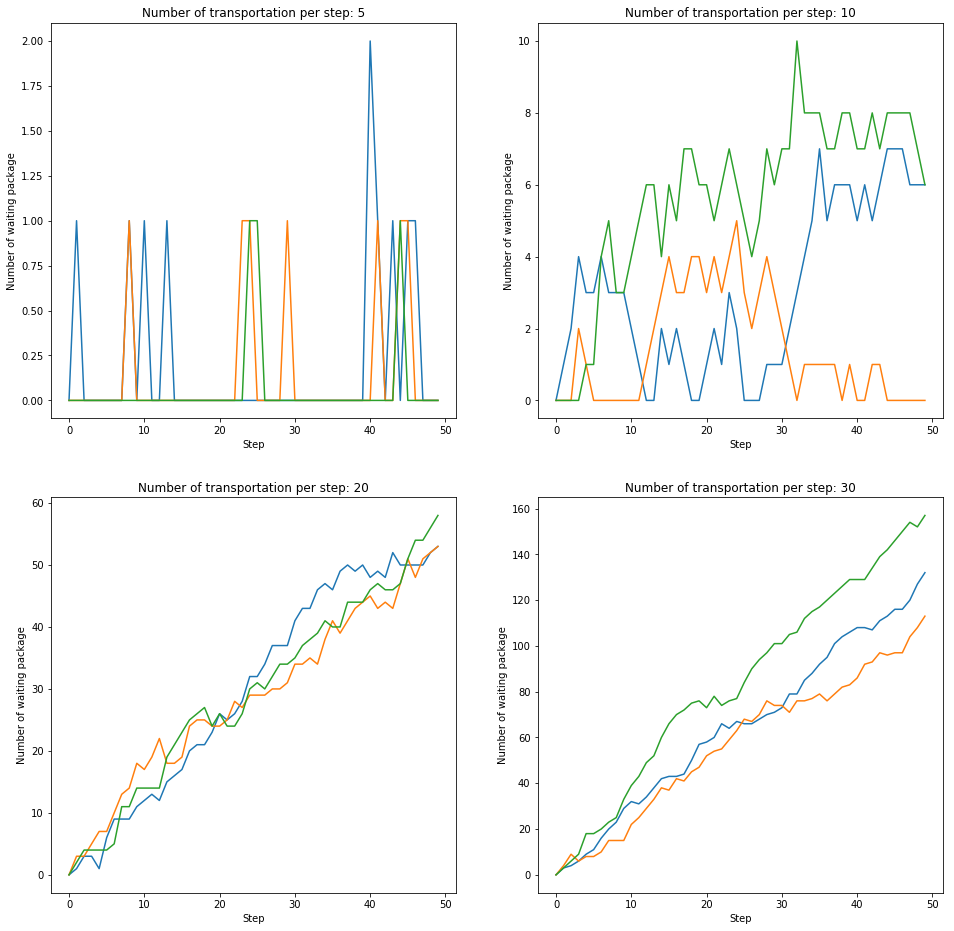

In [77]:
#Plot phase transition
j=1 
plt.figure(figsize=(16,16))
for i in [5, 10, 20, 30]:
    plt.subplot(2,2,j)
    for _ in range(3):
        sim = TransportationSimulation(g, n_routing_per_step=i)
        for _ in range(50):
            sim.update()
        plt.plot(range(sim.step), sim.metric_n_waiting_package)
        plt.xlabel('Step')
        plt.ylabel('Number of waiting package')
    
    plt.title('Number of transportation per step: {}'.format(i))
    j+=1
plt.show()

/Users/ash/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


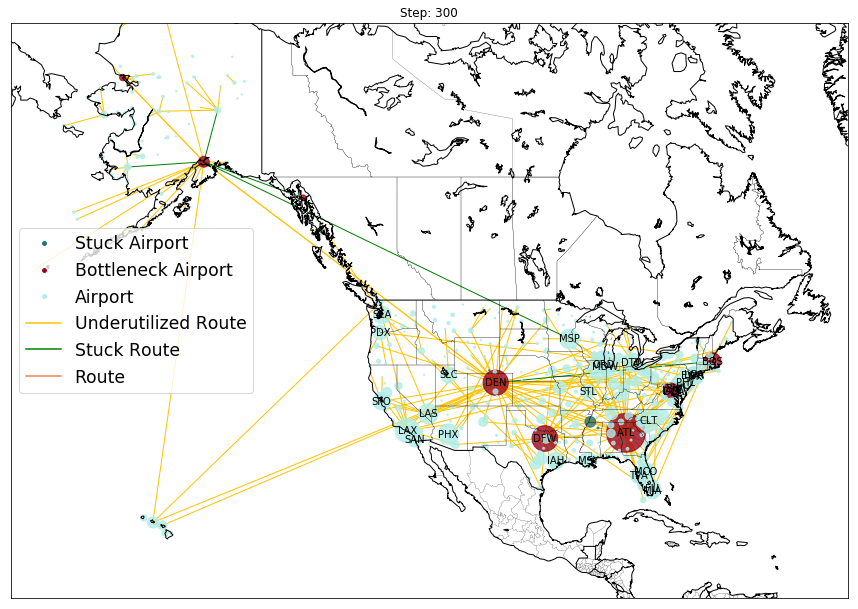

In [113]:
#Identify bottlenecks and underutilized routes
sim = TransportationSimulation(g, n_routing_per_step=5)
for _ in range(300):
    sim.update()
sim.observe()

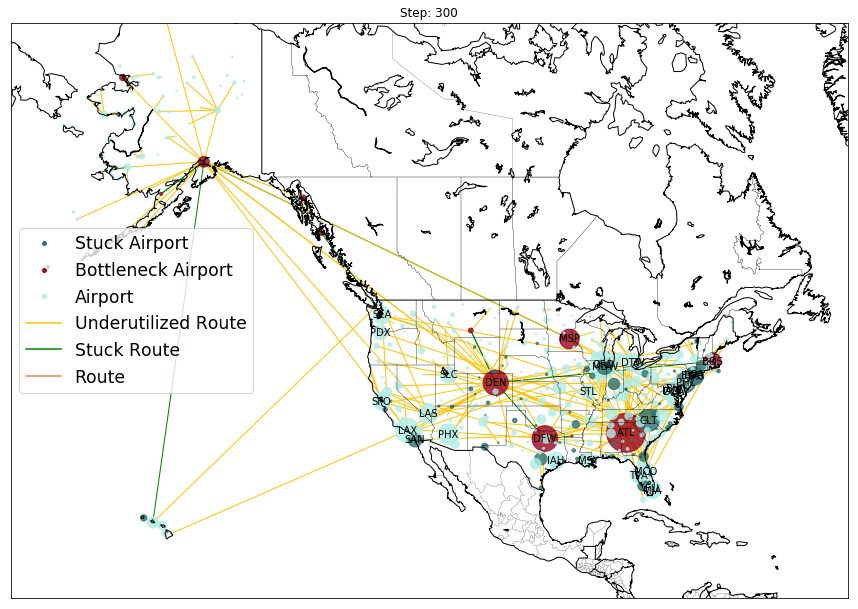

In [115]:
sim = TransportationSimulation(g, n_routing_per_step=10)
for _ in range(300):
    sim.update()
sim.observe()

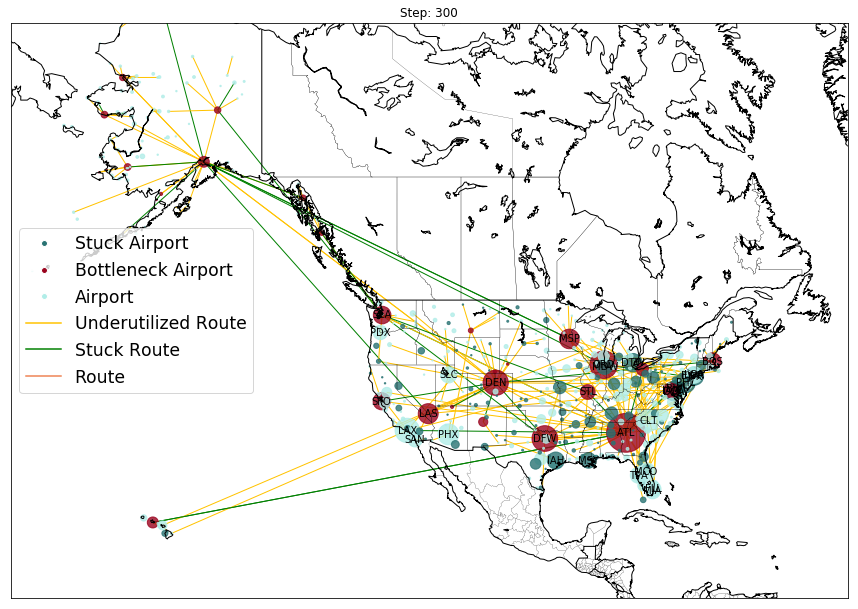

In [116]:
sim = TransportationSimulation(g, n_routing_per_step=20)
for _ in range(300):
    sim.update()
sim.observe()

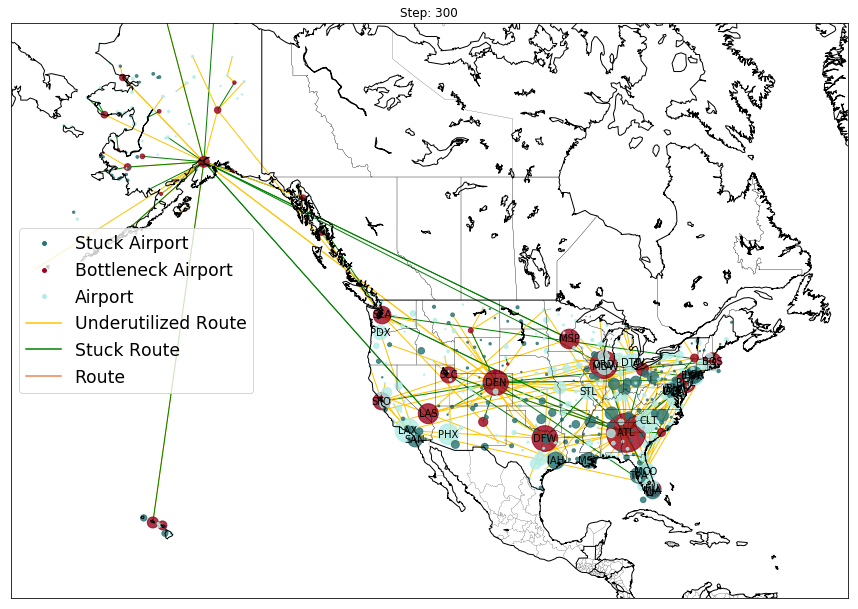

In [117]:
sim = TransportationSimulation(g, n_routing_per_step=30)
for _ in range(300):
    sim.update()
sim.observe()

In [139]:
#Calculate the distribution of metrics
n_stuck_node = []
n_bottleneck_node = []
mean_waiting_package = []
n_underutilized_route = []
n_stuck_route = []
for _ in range(100): 
    sim = TransportationSimulation(g, n_routing_per_step=10)
    for _ in range(100):
        sim.update()
    n_stuck_node.append(len(sim.metric_pending_node))
    n_bottleneck_node.append(len(sim.metric_bottleneck_node))
    mean_waiting_package.append(np.mean(sim.metric_n_waiting_package))
    n_underutilized_route.append(len(sim.metric_route_utilization))
    n_stuck_route.append(len(sim.metric_route_stuck))

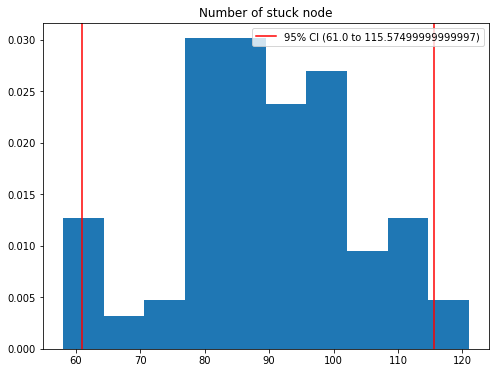

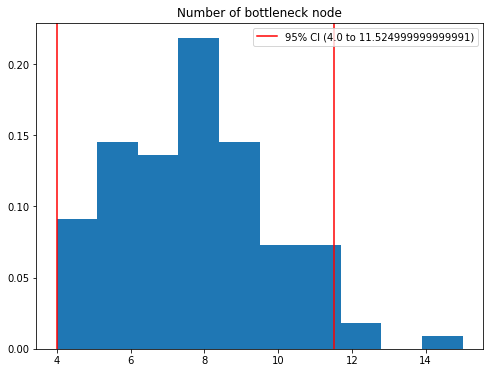

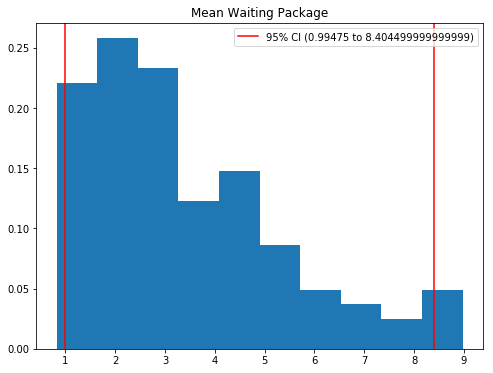

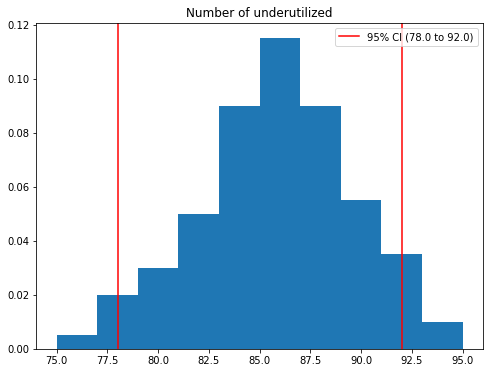

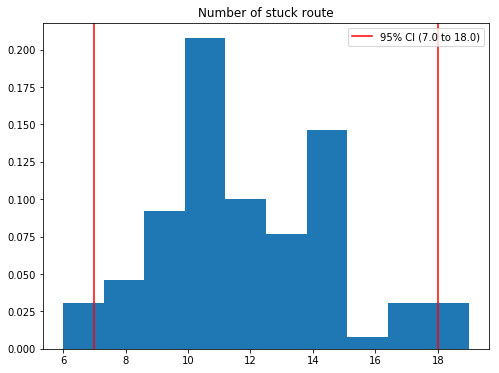

In [144]:
metrics = [n_stuck_node, n_bottleneck_node, mean_waiting_package, n_underutilized_route, n_stuck_route]
names = ['Number of stuck node', 'Number of bottleneck node', 'Mean Waiting Package', \
         'Number of underutilized', 'Number of stuck route']
for metric, name in zip(metrics, names) : 
    plt.figure(figsize=(8,6))
    plt.hist(metric, density=True, bins=10)
    bound1, bound2 = np.percentile(metric, (2.5, 97.5))
    plt.axvline(bound1, label='95% CI ({} to {})'.format(bound1, bound2), color='r')
    plt.axvline(bound2, color='r')
    plt.legend()
    plt.title(name)
    plt.show()